<a href="https://colab.research.google.com/github/MuhammadRivaldiAsyhari/CBIR/blob/main/CBIR-RIVALDI370.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
# set the matplotlib backend so figures can be saved in the background
!pip install --upgrade imutils

import matplotlib
matplotlib.use("Agg")
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
#from google.colab.patches import cv2_imshow
from imutils import build_montages
#from google.colab import files
import numpy as np
import argparse
import pickle
import shutil
import os
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Training

In [2]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64,128,256), latentDim=512):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			#x = MaxPooling2D(pool_size=(2, 2))
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim, name="encoded")(x)

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		x = Dense(np.prod(volumeSize[1:]))(latent)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			x = Conv2DTranspose(f, (3, 3), strides=2,padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
			# apply a CONV_TRANSPOSE => RELU => BN operation
			
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid", name="decoded")(x)

		# construct our autoencoder model
		autoencoder = Model(inputs, outputs, name="autoencoder")

		# return the autoencoder model
		return autoencoder

In [3]:
def visualize_predictions(decoded, gt, samples=4):
	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs


In [4]:
# construct the argument
args=["autoencoder.h5","recon_vis.png","plot.png"]

In [7]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import opendatasets as od

#{"username":"muhrivaldi","key":"87207ba662a6f50aaf46352d69910fbb"}
od.download("https://www.kaggle.com/datasets/theaayushbajaj/cbir-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhrivaldi
Your Kaggle Key: ··········


100%|██████████| 232M/232M [00:01<00:00, 209MB/s]


In [9]:
img_height=512
img_width=512
# load the image
folder_path='/content/cbir-dataset/dataset/'
images = []
files =os.listdir(folder_path)

In [10]:
i=0
for img in files[:1000]:
    if img.find('jpg')!=-1:
        if i % 250 == 0:
            print("%d images to array" % i)
        i+=1
        img = cv2.imread(folder_path+img)
        img= cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
        #print(img.shape)
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img)
images = np.vstack(images)
trainX=images
images=[]

0 images to array
250 images to array
500 images to array
750 images to array


In [11]:
i=0
images=[]
for img in files[:100]:
  if img.find('jpg')!=-1:
    if i % 250 == 0:
        print("%d images to array" % i)
    i+=1
    img = cv2.imread(folder_path+img)
    query = img_to_array(img)
    img= cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2GRAY)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
images = np.vstack(images)
testX=images
testX.shape
images=[]

0 images to array


In [12]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [13]:
EPOCHS = 18
INIT_LR = 1e-5
BS = 15
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
autoencoder = ConvAutoencoder.build(512,512,1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

# testing images, construct the visualization, and then save it
# to disk

Epoch 1/18
67/67 [==============================] - 1023s 15s/step - loss: 0.0822 - val_loss: 0.0490
Epoch 2/18
67/67 [==============================] - 1014s 15s/step - loss: 0.0510 - val_loss: 0.0486
Epoch 3/18
67/67 [==============================] - 1014s 15s/step - loss: 0.0415 - val_loss: 0.0481
Epoch 4/18
67/67 [==============================] - 1014s 15s/step - loss: 0.0355 - val_loss: 0.0461
Epoch 5/18
67/67 [==============================] - 1013s 15s/step - loss: 0.0314 - val_loss: 0.0428
Epoch 6/18
67/67 [==============================] - 1017s 15s/step - loss: 0.0280 - val_loss: 0.0360
Epoch 7/18
67/67 [==============================] - 1014s 15s/step - loss: 0.0255 - val_loss: 0.0288
Epoch 8/18
67/67 [==============================] - 1017s 15s/step - loss: 0.0236 - val_loss: 0.0235
Epoch 9/18
67/67 [==============================] - 1016s 15s/step - loss: 0.0218 - val_loss: 0.0202
Epoch 10/18
67/67 [==============================] - 1024s 15s/step - loss: 0.0201 - val_lo

In [15]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite(args[1], vis)

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args[2])



[INFO] making predictions...


In [16]:
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(args[0], save_format="h5")

[INFO] saving autoencoder...


# Visualization of recontructing image

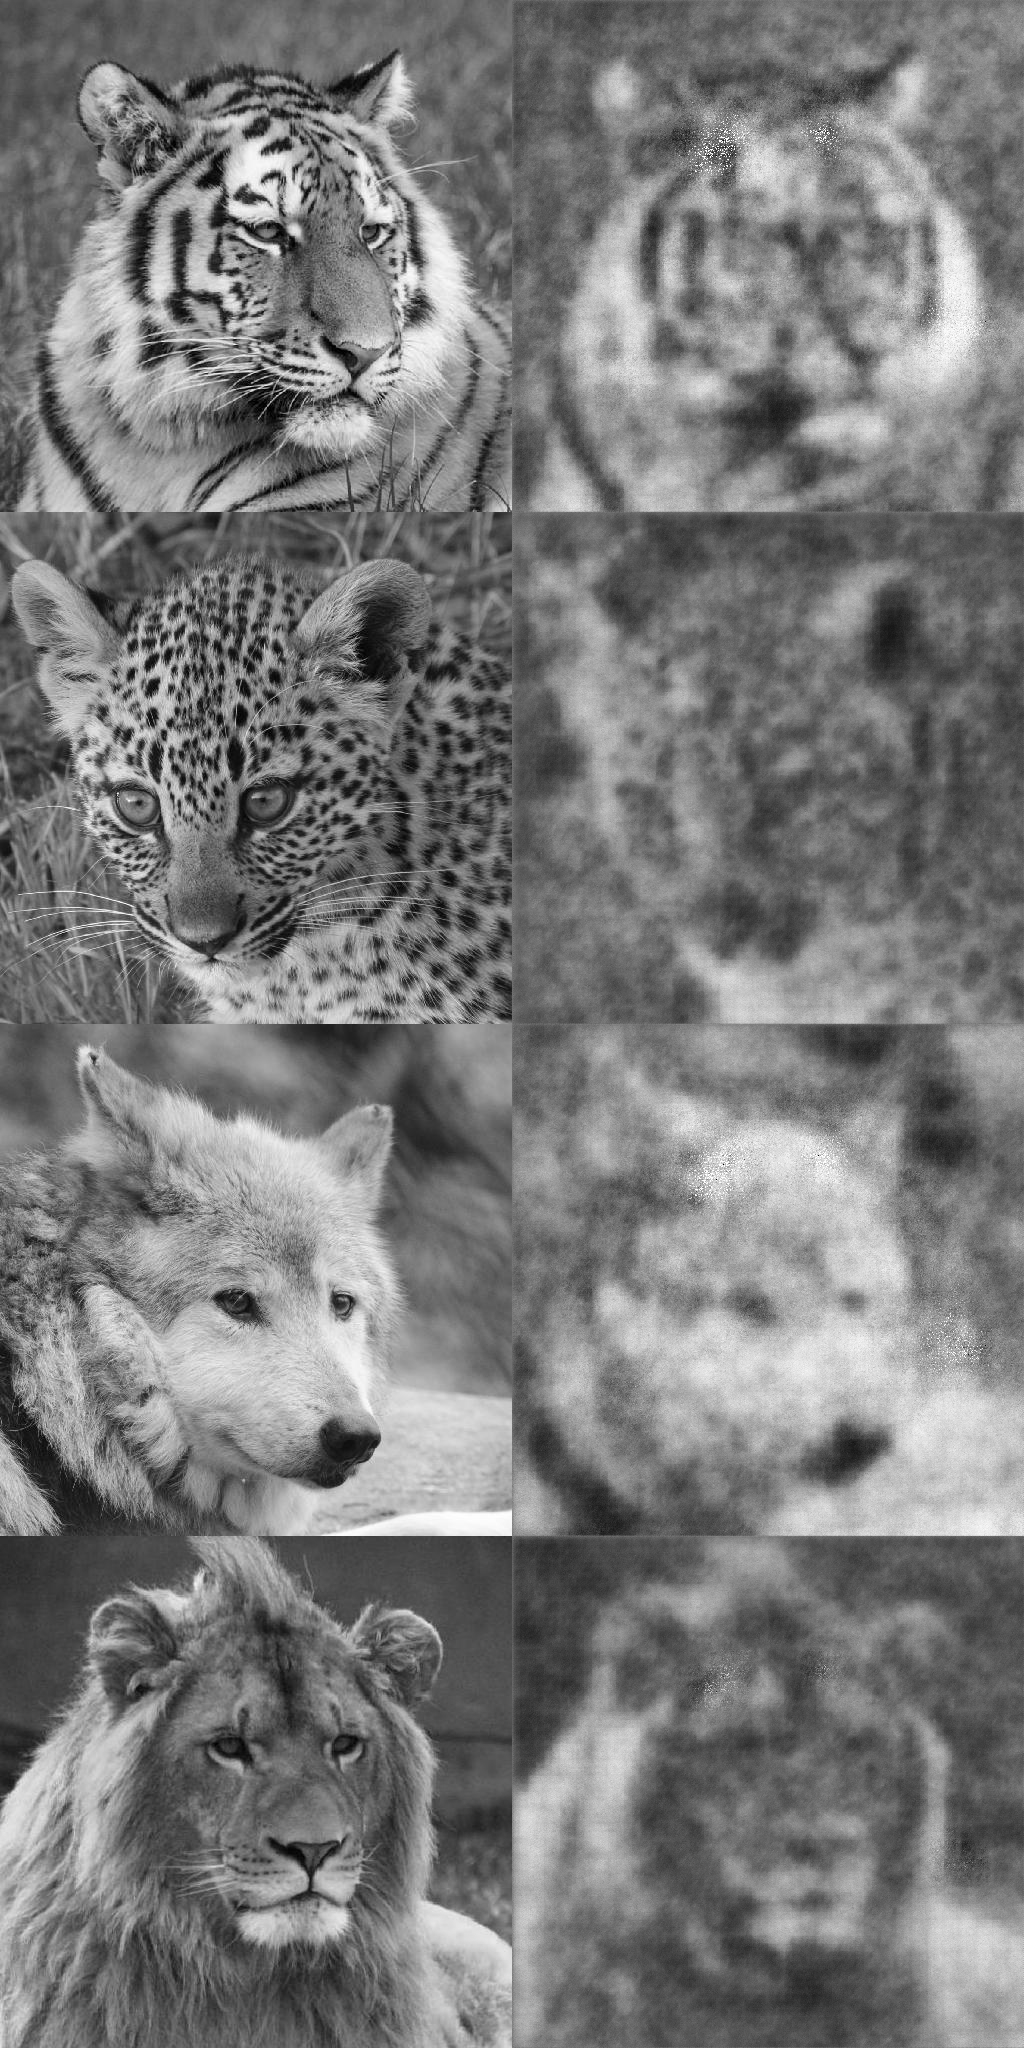

In [17]:
from IPython.display import Image
Image('./recon_vis.png')

## Testing the Model

In [18]:
args=["/content/drive/My Drive/weights/autoencoder.h5","/content/index.pickle"]

In [ ]:
img_height=512
img_width=512
# load the image
folder_path='/content/cbir-dataset/dataset/'
images = []
trainX=[]
files =os.listdir(folder_path)
i=0
for img in files:
    if img.find('jpg')!=-1:
      if i % 250 == 0:
        print("%d images to array" % i)
      i+=1
      img = cv2.imread(folder_path+img)
      img= cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
      #print(img.shape)
      img = img_to_array(img)
      img = np.expand_dims(img, axis=0)
      images.append(img)
      
images = np.vstack(images)
trainX=images
trainX = trainX.astype("float32") / 255.0
images=[]

0 images to array
250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array


In [ ]:
print("[INFO] loading autoencoder model...")
autoencoder = load_model(args[0])
# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)
# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features = encoder.predict(trainX)

In [ ]:
indexes = list(range(0, trainX.shape[0]))
data = {"indexes": indexes, "features": features}
# write the data dictionary to disk
print("[INFO] saving index...")
f = open(args[1], "wb")
f.write(pickle.dumps(data))
f.close()

In [ ]:
uploaded =files.upload()
for fn in uploaded.keys():
  print(fn)
  testX=cv2.imread(fn)
  testX = cv2.cvtColor(np.float32(testX), cv2.COLOR_RGB2GRAY)
  cv2_imshow(testX)
  testX = testX.astype("float32") / 255.0
  testX = np.expand_dims(testX, axis=0)


In [ ]:
testX.shape

In [ ]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

def perform_search(queryFeatures, index, maxResults=64):
	# initialize our list of results
	results = []

	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
		d = euclidean(queryFeatures, index["features"][i])
		results.append((d, i))

	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]

	# return the list of results
	return results
args=["/content/drive/My Drive/weights/autoencoder.h5","/content/index.pickle",1]
# load the autoencoder model and index from disk
print("[INFO] loading autoencoder and index...")
autoencoder = load_model(args[0])
index = pickle.loads(open(args[1], "rb").read())

# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)




In [ ]:
# quantify the contents of our input testing images using the encoder
print("[INFO] encoding testing images...")
features = encoder.predict(testX)

# randomly sample a set of testing query image indexes
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=args[2],
	replace=False)

queryIdxs

In [ ]:
# loop over the testing indexes
for i in queryIdxs:
	# take the features for the current image, find all similar
	# images in our dataset, and then initialize our list of result
	# images
	queryFeatures = features[i]
	results = perform_search(queryFeatures, index, maxResults=20)
	print(len(results))
	images = []
	for (d, j) in results:
		# grab the result image, convert it back to the range
		# [0, 255], and then update the images list
		image = (trainX[j] * 255).astype("uint8")
		image= cv2.cvtColor(np.float32(image), cv2.COLOR_GRAY2RGB)
		#image = np.dstack([image] * 3)
		images.append(image)
	# display the query image
	query = (testX[i] * 255).astype("uint8")
	cv2_imshow(query)

	# build a montage from the results and display it
	montage = build_montages(images, (512, 512), (5,4))[0]
	cv2_imshow( montage)
	cv2.waitKey(0)
